In [1]:
import pandas as pd
import numpy as np
import datetime
import talib
import matplotlib.pyplot as plt
from wmpy.conf.settings import product_info_df, trade_days_list
from wmpy.trader.utility import get_previous_date, load_bar, load_bar_period, get_commission, map_parallel, get_trading_days, get_main_contract, read_sql_bar, get_symbol_name, np_shift, update_main_contract, get_main_contract_from_json
from wmpy.app.cta_backtester.backtesting_bar import cal_all_pnl, cal_daily_pnl # 注意这里是backtesting_bar

In [2]:
#过滤掉非交易时间
def bar_filter(bar_df, contract=None):
    def is_trading_time(dt):
        condition = (
            (dt.time() >= datetime.time(9, 0) and dt.time() < datetime.time(11, 30))    # 上午
         or (dt.time() >= datetime.time(13, 0) and dt.time() < datetime.time(15, 0))  # 下午
         or (dt.time() >= datetime.time(21, 0) and dt.time() < datetime.time(23, 0)))   # 夜盘
        return condition
    bool_list = [is_trading_time(x) for x in bar_df.index]
    return bar_df.loc[bool_list].copy()

In [3]:
#查看期货品种
import qgrid
qgrid.show_grid(product_info_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# hp滤波
def hp(x, lamb = 50):
    def D_matrix(N):
        D = np.zeros((N-1,N))
        D[:,1:] = np.eye(N-1)
        D[:,:-1] -= np.eye(N-1)
        """D1
        [[-1.  1.  0. ...  0.  0.  0.]
         [ 0. -1.  1. ...  0.  0.  0.]
         [ 0.  0. -1. ...  0.  0.  0.]
         ...
         [ 0.  0.  0. ...  1.  0.  0.]
         [ 0.  0.  0. ... -1.  1.  0.]
         [ 0.  0.  0. ...  0. -1.  1.]]
        """
        return D
    N = len(x)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    D = D2 @ D1
    y = np.linalg.inv((np.eye(N)+lamb*D.T@D))@ x
    return y[-1]

In [5]:
# l1滤波
def l1(x, lamb1 = 50, lamb2 = 50):
    def D_matrix(N):
        D = np.zeros((N-1,N))
        D[:,1:] = np.eye(N-1)
        D[:,:-1] -= np.eye(N-1)
        """D1
        [[-1.  1.  0. ...  0.  0.  0.]
         [ 0. -1.  1. ...  0.  0.  0.]
         [ 0.  0. -1. ...  0.  0.  0.]
         ...
         [ 0.  0.  0. ...  1.  0.  0.]
         [ 0.  0.  0. ... -1.  1.  0.]
         [ 0.  0.  0. ...  0. -1.  1.]]
        """
        return D
    N = len(x)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    D = D2 @ D1
    import cvxpy as cp
    # Solve l1 trend filtering problem.
    y = cp.Variable(shape=N)
    obj = cp.Minimize(cp.sum_squares(y - x)+ lamb1 * cp.norm(D1*y, 1)+lamb2 * cp.norm(D*y,1) )
    prob = cp.Problem(obj)
    prob.solve(solver=cp.CVXOPT, verbose=False)
    return np.array(y.value)[-1]

In [6]:
# Fourier滤波
def Fourier_filter(x,k=50):
    y = np.fft.fft(x)
    y[k:] = 0
    x_ = np.fft.ifft(y)
    res = []
    for i in range(len(x_)):
        res.append(x_[i].real)
    return res[-1]

In [7]:
from wmpy.trader.utility import update_main_contract, get_main_contract_from_json
date = 20201231
contract = 'rb2105' # 当天的主力合约

In [8]:
bar_df = load_bar(contract, date)
bar_df = bar_filter(bar_df) # 过滤非交易时间（最后一分钟虽然有行情，但无法交易，含有的信息量也很少）
bar_df

,contract,exchange,interval,volume,open_interest,open_price,high_price,low_price,close_price,bid_price_1,ask_price_1
datetime,,,,,,,,,,,
2020-12-30 21:00:00,rb2105,SHFE,1m,29260.0,1183578.0,4257.0,4263.0,4254.0,4263.0,4257.0,4259.0
2020-12-30 21:01:00,rb2105,SHFE,1m,22412.0,1184489.0,4264.0,4264.0,4258.0,4258.0,4263.0,4264.0
2020-12-30 21:02:00,rb2105,SHFE,1m,16091.0,1185280.0,4258.0,4266.0,4256.0,4265.0,4258.0,4259.0
2020-12-30 21:03:00,rb2105,SHFE,1m,21586.0,1184805.0,4265.0,4274.0,4265.0,4271.0,4265.0,4266.0
2020-12-30 21:04:00,rb2105,SHFE,1m,12940.0,1184325.0,4272.0,4276.0,4271.0,4272.0,4271.0,4272.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:55:00,rb2105,SHFE,1m,14902.0,1219791.0,4370.0,4378.0,4366.0,4377.0,4369.0,4370.0
2020-12-31 14:56:00,rb2105,SHFE,1m,24563.0,1221455.0,4377.0,4386.0,4375.0,4385.0,4376.0,4377.0
2020-12-31 14:57:00,rb2105,SHFE,1m,14739.0,1219919.0,4384.0,4389.0,4383.0,4384.0,4384.0,4385.0


In [9]:
temp_df = bar_df.copy()
window = 100
temp_df['hp_filter'] = temp_df['close_price'].rolling(window).apply(hp,args=(1000,))
temp_df['l1_filter'] = temp_df['close_price'].rolling(window).apply(l1,args=(10,10,))
temp_df['Fourier_filter'] = temp_df['close_price'].rolling(window).apply(Fourier_filter,args=(3,))

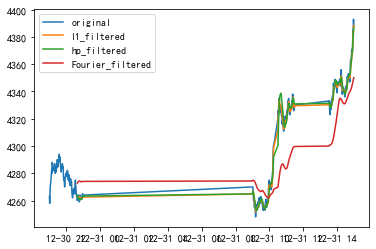

In [10]:
plt.plot(temp_df['close_price'], label='original')
plt.plot(temp_df['l1_filter'], label='l1_filtered')
plt.plot(temp_df['hp_filter'], label='hp_filtered')
plt.plot(temp_df['Fourier_filter'], label='Fourier_filtered')
plt.legend()
plt.show()

注：由于L1滤波运算缓慢，且存在不收敛的情况，在下面设计策略时先不考虑。

In [94]:
# 基于HP滤波和Fourier滤波的策略
# 可以发现当HP滤波后的均线上穿Fourier滤波后的均线时，价格上突，开仓做多
# 当HP滤波后的均线下穿Fourier滤波后的均线时，价格下突，开仓做空
def HF_strategy(bar_df, date, contract, parameter_dict=None):
    LAMB = parameter_dict['LAMB']
    FOURIER_K = parameter_dict['FOURIER_K']
    WINDOW = parameter_dict['WINDOW']
    
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    
    temp_df = data_df.copy()   # 防止改掉原数据，引起不必要的bug
    temp_df['hp_filter'] = temp_df['close_price'].rolling(WINDOW).apply(hp,args=(LAMB,))
    temp_df['Fourier_filter'] = temp_df['close_price'].rolling(WINDOW).apply(Fourier_filter,args=(FOURIER_K,))

    def _cal_signal(x):
            hp = x['hp_filter']
            Fourier = x['Fourier_filter']

            if pd.isna(hp) or pd.isna(Fourier):    # 如果任意一个值为空
                signal = 0
            elif hp >= Fourier:
                signal = 1
            else:
                signal = -1
            return signal

    temp_df['signal'] = temp_df.apply(_cal_signal, axis=1) # 对temp_df的每一行做判断
    temp_df['position'] = temp_df['signal'].shift(1)       # 根据上一分钟的信号决定仓位
    temp_df = pd.DataFrame(temp_df, index=bar_df.index)
    signal_ser = temp_df['signal'].copy()
    position_ser = temp_df['position'].copy()
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0


    ## 返回这段时间的持仓序列
    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [12]:
# 网格搜索调整参数
best_score = -10000
for lamb in [10,100,1000]:
    for k in [5,10]:
        # 对于每种参数可能的组合，进行一次训练
        parameter_dict = dict(WINDOW = 100, LAMB = lamb, FOURIER_K = k)
        df = cal_all_pnl(20200901, 20201231, HF_strategy, parameter_dict, symbol='rb', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=False)
        df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
        score = df['net_pnl'].sum()
        # 找到表现最好的参数
        if score > best_score:
            best_score = score
            best_parameters = dict(WINDOW = 100,LAMB = lamb, FOURIER_K = k)

In [13]:
best_parameters

{'WINDOW': 100, 'LAMB': 1000, 'FOURIER_K': 10}

In [128]:
df = cal_all_pnl(20200901, 20210228, HF_strategy, best_parameters, symbol='rb', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=True)

100%|██████████| 117/117 [06:01<00:00,  3.09s/it]


In [96]:
# 碰到了涨跌停，把df处理一下
df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0

In [129]:
df

,total_pnl,net_pnl,commission,num,holding_period
2020-09-01,-23.0,-29.0393,6.0393,8.0,342.0
2020-09-02,-23.0,-28.2803,5.2803,7.0,342.0
2020-09-03,27.0,23.9667,3.0333,4.0,342.0
2020-09-04,-3.0,-13.5581,10.5581,14.0,342.0
2020-09-07,-52.0,-62.5140,10.5140,14.0,342.0
...,...,...,...,...,...
2021-02-22,59.0,51.7071,7.2929,8.0,342.0
2021-02-23,32.0,25.5780,6.4220,7.0,342.0
2021-02-24,-109.0,-118.1467,9.1467,10.0,342.0
2021-02-25,-3.0,-8.5971,5.5971,6.0,342.0


------------------------------
交易天数：	117
区间收益：	-1040.67
日度胜率：	41.03%
日盈亏比：	0.90:1
------------------------------
最大回撤：	1042.60
回撤起始：	2020-09-15
回撤结束：	2020-12-04
------------------------------
交易次数：	930.0
每日平均：	7.95
每笔收益：	-1.12
------------------------------
信息比率：	-0.19
------------------------------


(-1040.6682999999362,
 1042.5969999999652,
 -1.118998172042942,
 930.0,
 117,
 -0.18603698495168436)

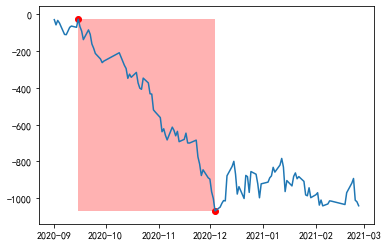

In [130]:
from wmpy.trader.utility import performance_summary
performance_summary(df, key='net_pnl', _plot=True, _print=True)

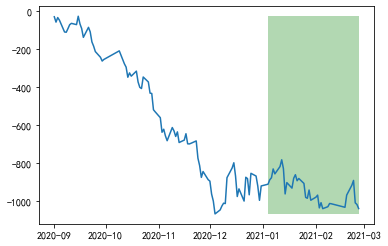

In [131]:
# 20210101后为样本外数据
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)

In [101]:
from wmpy.trader.utility import update_main_contract, get_main_contract_from_json
date = 20201231
contract = 'IF2101' # 当天的主力合约

In [102]:
bar_df = load_bar(contract, date)
bar_df = bar_filter(bar_df) # 过滤非交易时间（最后一分钟虽然有行情，但无法交易，含有的信息量也很少）
bar_df

,contract,exchange,interval,volume,open_interest,open_price,high_price,low_price,close_price,bid_price_1,ask_price_1
datetime,,,,,,,,,,,
2020-12-31 09:30:00,IF2101,CFFEX,1m,1621.0,81996.0,5132.6,5136.6,5125.0,5136.4,5132.0,5133.4
2020-12-31 09:31:00,IF2101,CFFEX,1m,1055.0,81343.0,5136.2,5146.4,5136.2,5146.4,5136.2,5136.6
2020-12-31 09:32:00,IF2101,CFFEX,1m,823.0,80933.0,5146.6,5148.8,5145.2,5148.0,5146.4,5146.8
2020-12-31 09:33:00,IF2101,CFFEX,1m,917.0,80484.0,5147.8,5153.6,5147.2,5153.6,5147.8,5148.2
2020-12-31 09:34:00,IF2101,CFFEX,1m,754.0,80032.0,5154.0,5156.8,5150.8,5155.0,5153.8,5154.6
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:55:00,IF2101,CFFEX,1m,468.0,89496.0,5217.8,5218.4,5216.4,5217.8,5217.6,5218.2
2020-12-31 14:56:00,IF2101,CFFEX,1m,502.0,89727.0,5217.8,5219.8,5216.6,5219.0,5217.6,5218.0
2020-12-31 14:57:00,IF2101,CFFEX,1m,704.0,90073.0,5219.0,5219.0,5215.0,5218.2,5218.8,5219.2


In [105]:
temp_df = bar_df.copy()
temp_df['Fourier_filter'] = temp_df['close_price'].rolling(40).apply(Fourier_filter,args=(2,))

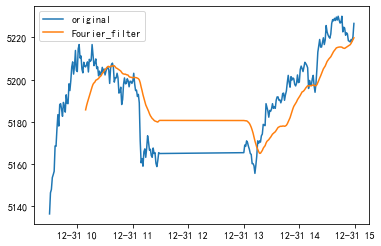

In [106]:
plt.plot(temp_df['close_price'], label='original')
plt.plot(temp_df['Fourier_filter'], label='Fourier_filter')
plt.legend()
plt.show()

In [14]:
temp_df['Fourier_diff'] = temp_df['Fourier_filter'].diff()

In [16]:
temp_df['Fourier_diff']

datetime
2020-12-30 21:00:00         NaN
2020-12-30 21:01:00         NaN
2020-12-30 21:02:00         NaN
2020-12-30 21:03:00         NaN
2020-12-30 21:04:00         NaN
                         ...   
2020-12-31 14:55:00    0.767659
2020-12-31 14:56:00    0.927572
2020-12-31 14:57:00    0.886231
2020-12-31 14:58:00    1.103524
2020-12-31 14:59:00    0.879283
Name: Fourier_diff, Length: 346, dtype: float64

In [67]:
# 我们发现当Fourier滤波去掉足够多的高频信号时，曲线将变得十分平滑，我们用它来预测涨跌的趋势
# 当这条均线上升时，平空做多；当这条均线下降时，平多做空
def F_strategy(bar_df, date, contract, parameter_dict=None):
    FOURIER_K = parameter_dict['FOURIER_K']
    WINDOW = parameter_dict['WINDOW']
    
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    
    temp_df = data_df.copy()   # 防止改掉原数据，引起不必要的bug
    temp_df['Fourier_filter'] = temp_df['close_price'].rolling(WINDOW).apply(Fourier_filter,args=(FOURIER_K,))
    DIFF = temp_df['Fourier_filter'].diff()

    signal_ser = pd.Series(data = 0,index = bar_df.index) 
    
    for i in range(1,len(signal_ser)):
        last_signal = signal_ser[i-1]
        if last_signal == 0:
            if DIFF[i]>=0 :
                signal_ser[i] = 1
            else:
                signal_ser[i] = -1
        elif last_signal == 1:
            if DIFF[i] < 0:
                signal_ser[i] = -1
            else:
                signal_ser[i] = 1
        else:
            if DIFF[i] > 0:
                signal_ser[i] = 1
            else:
                signal_ser[i] = -1
    
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0


    ## 返回这段时间的持仓序列
    position_ser = signal_ser.shift(1)
    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [114]:
# 网格搜索调整参数
best_score = -10000
for window in [30,60,90,120]:
    for k in [1,3,5]:
        # 对于每种参数可能的组合，进行一次训练
        parameter_dict = dict(WINDOW = window, FOURIER_K = k)
        df = cal_all_pnl(20200901, 20201231, F_strategy, parameter_dict, symbol='IF', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=False)
        df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
        score = df['net_pnl'].sum()
        # 找到表现最好的参数
        if score > best_score:
            best_score = score
            best_parameters = dict(WINDOW = window, FOURIER_K = k)

In [115]:
best_parameters

{'WINDOW': 90, 'FOURIER_K': 1}

In [124]:
df = cal_all_pnl(20200901, 20210228, F_strategy, best_parameters, symbol='IF', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=True)

100%|██████████| 117/117 [00:17<00:00,  6.77it/s]


------------------------------
交易天数：	117
区间收益：	-287.65
日度胜率：	44.44%
日盈亏比：	1.11:1
------------------------------
最大回撤：	968.38
回撤起始：	2020-09-14
回撤结束：	2021-02-10
------------------------------
交易次数：	927.0
每日平均：	7.92
每笔收益：	-0.31
------------------------------
信息比率：	-0.04
------------------------------


(-287.6515196004557,
 968.377500400401,
 -0.3103036888893805,
 927.0,
 117,
 -0.0434015495869145)

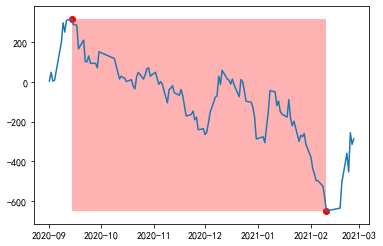

In [125]:
from wmpy.trader.utility import performance_summary
performance_summary(df, key='net_pnl', _plot=True, _print=True)

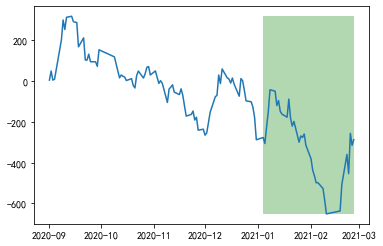

In [126]:
# 20210101后为样本外数据
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)